In [205]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('monokai')

# Nike vs. Adidas shoes EDA

#### by: Moiezali Ismail

## Introduction

**The Context**  
This project compares Adidas-Nike to provide insight into the difference for pricing and discount distribution in order to uncover insights about brand positioning.

**The Key Questions**
- How do the key numerical factors: price, discounts, ratings, and contrast between Adidas and Nike? Are the difference significant?
- Is there a correlation between ratings and listing prices and what does this say about the brand?

**Executive Summary**
Nike's strategy of higher pricing and ratings suggests a premium market position, while Adidas offers significant discounts, presenting a strong value proposition. This study investigates whether Nike's dominance is primarily due to its brand perception, driven by aggressive marketing and high-profile endorsements, as compared to Adidas and other competitors.

# Table of contents

#### Table of contents: 
- [Initial observations](#Initial-observations)
- [Data cleaning](#Data-cleaning)
- [Data cleaning summary](#Data-cleaning-summary)
- [Analysis](#Analysis)
- [Exporting to cloud](#Exporting-to-cloud) 
- [Insights + recommendations](#Insights-and-recommendations) 
- [Conclusion](#Conclusion)

In [206]:
import plotly.io as pio
pio.renderers.default = "svg"

import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import pearsonr, uniform, norm, t, shapiro, mannwhitneyu, ranksums
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns  
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format

In [207]:
data = pd.read_csv('/Users/moiezismail/projects/shoes/shoes_raw_data.csv')

## Initial observations

In [208]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3268 entries, 0 to 3267
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product Name   3268 non-null   object 
 1   Product ID     3268 non-null   object 
 2   Listing Price  3268 non-null   int64  
 3   Sale Price     3268 non-null   int64  
 4   Discount       3268 non-null   int64  
 5   Brand          3268 non-null   object 
 6   Description    3265 non-null   object 
 7   Rating         3268 non-null   float64
 8   Reviews        3268 non-null   int64  
 9   Last Visited   3268 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 255.4+ KB


#### Observations
- 3268
- the data is limited as we do not have a sales variable which we can use to make a prediction nor are there any units sold, location/store branch, or invoice date data
- 3268 entries with the Description column missing only 3 entries
- last visited column is irrelevant for this analysis 

In [209]:
f"# of unique product ID: {data['Product ID'].nunique()}, # of unique product names: {data['Product Name'].nunique()}"


'# of unique product ID: 3179, # of unique product names: 1531'

#### Observations
- not every product ID is unique

In [210]:
# 5 random rows to have a look at the data
data.sample(5)

,Product Name,Product ID,Listing Price,Sale Price,Discount,Brand,Description,Rating,Reviews,Last Visited
543,Men's adidas Running Furio Lite 1.0 Shoes,CL7333,3599,2159,40,Adidas CORE / NEO,The lightweight adidas Furio Lite 1.0 Running ...,4.30,70,2020-04-13T15:06:38
2739,Nike Phantom Vision Academy Dynamic Fit TF,AO3269-717,8495,5947,0,Nike,The Nike Phantom Vision Academy Dynamic Fit TF...,4.00,3,2020-04-13T15:28:22
2596,Men's Sport Inspired Roguera Shoes,EG2659,5599,5599,0,Adidas CORE / NEO,Feel the power of the fitness trends of the '8...,5.00,78,2020-04-13T15:07:58
2136,Men's adidas Sport Inspired Questar Rise Shoes,F34944,6999,3499,50,Adidas CORE / NEO,"Designed with a rugged, outdoor look, these ru...",1.50,52,2020-04-13T15:07:42
2280,MEN'S ADIDAS FOOTBALL NEMEZIZ 18.1 FIRM GROUND...,DB2080,12999,6499,50,Adidas SPORT PERFORMANCE,Create with no limits. Strike with no warning....,3.60,24,2020-04-13T15:07:47


#### Observations
- listing and sale price is without a decimal, so the interger value is in the tens of thousands
- discount is a % not an absolute $ vallue
- Nike has products with listing price as 0(non-null missing value) and a sale price which would skew analysis and aggregation 
- Reviews are a count rather than text

#### Count non-null missing values ( 0s) 

In [211]:
zero_ratings_count = (data['Rating'] == 0).sum()
zero_listing_prices_count = (data['Listing Price'] == 0).sum()

print(f"Rating: {zero_ratings_count}")
print(f"Listing price: {zero_listing_prices_count}")


Rating: 302
Listing price: 426


#### observations
- Ratings and listing price have quite a large number of 0s where 0s don't make sense even the worst Nike shoes won't zero a 0 rating by everyone nor does a 0 for listing price mean it's free

## Data cleaning 

#### cleaning: drop duplicates and irrelevant columns

In [212]:
data.drop_duplicates(subset=['Product ID', 'Product Name'], inplace=True)

data.drop(columns=['Last Visited', 'Reviews'], inplace=True)

####  cleaning: correcting the format for price 

In [213]:
data[['Listing Price','Sale Price']] = (data[['Listing Price','Sale Price']] / 100).round(1)

In [214]:
data.sample(2)

,Product Name,Product ID,Listing Price,Sale Price,Discount,Brand,Description,Rating
621,Women's adidas Originals Superstar Pure LT Shoes,FV3352,110.00,110.00,0,Adidas ORIGINALS,Originally made for basketball courts in the '...,4.10
873,Women's adidas Khoe Run Shoes,F36513,56.00,28.00,50,Adidas CORE / NEO,Running style with a feminine edge. These wome...,3.80


#### renaming some columns

In [215]:
data.rename(columns={'Discount': 'Discount %', 'Product ID':'Product_ID'}, inplace=True)

#### count the number of Nike products vs. Adidas


In [216]:
nike_prods = sum(data["Brand"].str.contains("Nike", case=True))
adidas_prods = 3268 - nike_prods

f"Nike products:{nike_prods} and Adidas products:{adidas_prods} so abbout 75% more products adidas products than Nike" 


'Nike products:554 and Adidas products:2714 so abbout 75% more products adidas products than Nike'

#### creating binary category for products into either Nike or Adidas

In [217]:
data['Company'] = data['Brand'].apply(
    lambda x: 'Nike' if 'Nike' in x else 'Adidas' if 'Adidas' in x else 'Other')

data.drop('Brand', axis=1, inplace=True)

In [218]:
# Check to see if there are only 2 different values in the Company column as intended 
data.Company.nunique()

2

In [219]:
(data[data['Company'] == 'Nike']['Listing Price']== 0).sum()

362

#### Observation
- Nike data has missing non-null values for listing price; we'll have to impute them as sale price if it's 0. 

#### impute listing price from sales price 
- Essentially, the following code swaps the values of 'Sale Price' into 'Listing Price' where 'Listing Price' is zero and sets 'Sale Price' to zero for those cases. 

In [220]:
# Create a boolean mask for rows where 'Listing Price' is 0
zero_rows = (data['Listing Price'] == 0)

# Use boolean indexing to update the values in 'Listing Price' and 'Sale Price' columns
data.loc[zero_rows, 'Listing Price'] = data.loc[zero_rows, 'Sale Price']
data.loc[zero_rows, 'Sale Price'] = 0

In [221]:
# 0 as a Sale price does not make sense as shoes cannot be discounted to
# the point of being free 
data['Sale Price'].replace(0, np.nan, inplace=True)

In [222]:
data.sample(3)

,Product Name,Product_ID,Listing Price,Sale Price,Discount %,Description,Rating,Company
494,Women's adidas Sport Inspired Hyperon 1.0 Shoes,CM4828,30.00,30.00,0,The adidas Hyperon Running-inspired shoes for ...,4.70,Adidas
629,Women's adidas Originals NMD_R1 Primeknit Shoes,CG6270,140.00,70.00,50,"With a nod to technical outerwear, these shoes...",3.20,Adidas
1018,Women's adidas RUNNING cosmic 2 Low Shoes,S80662,60.00,24.00,60,These women's running shoes deliver a cloudlik...,2.00,Adidas


#### cleaning: impute the % discount if Nike products have a different listing price than sale price excluding zero

In [223]:
data['Discount %'] = data.apply(lambda row: 
                            (row['Listing Price'] - row['Sale Price']) / row['Listing Price'] 
                            * 100 if row['Sale Price'] != 0 else 0, axis=1)

#Round the % to a whole number for neater analysis
data[['Listing Price','Sale Price','Discount %']] = np.round(data[[
    'Listing Price','Sale Price','Discount %']])

# Impute the Sale Price with Listing Price where Discount % is 0
data.loc[data['Discount %'] == 0, 'Sale Price'] = data['Listing Price']

In [224]:
data.sample(3)

,Product Name,Product_ID,Listing Price,Sale Price,Discount %,Description,Rating,Company
236,Men's adidas Outdoor Naha Shoes,CM0009,60.00,30.00,50.00,"Get maximum support, comfort and a refreshed l...",4.80,Adidas
2294,men's ADIDAS RUNNING SUPERNOVA SHOES,CG4019,120.00,60.00,50.00,These men's neutral running shoes powered worl...,3.50,Adidas
290,Women's adidas Originals Tubular Shadow Shoes,CG6164,80.00,40.00,50.00,The tire-inspired sole of the Tubular sneaker ...,3.30,Adidas


#### cleaning: imputing the mean into NULL 
- 1) turn non-null missing values(i.e. 0) into null
- 2) calculate mean from leftover values 
- 3) impute that aggregated value into the NaN cells(formerly 0)

In [225]:
data['Rating'] = data['Rating'].replace(0, np.nan).fillna(data['Rating'].mean())

In [226]:
data[['Listing Price', 
      'Sale Price', 
      'Discount %']] = data[['Listing Price', 
                             'Sale Price',
                             'Discount %']].fillna(0).astype('int64')

In [227]:
data.sample(5)

,Product Name,Product_ID,Listing Price,Sale Price,Discount %,Description,Rating,Company
3075,Nike Air Max 90,CU0675-300,140,98,30,"Redesigned for casual wear, the Nike Air Max 9...",5.00,Nike
783,Men's adidas Sport Inspired Glenn M Shoes,CM4550,25,18,30,The adidas Glenn M shoes for men crafted with ...,2.60,Adidas
2110,Men's adidas Sport Inspired Drogo Shoes,CL7629,27,19,30,"Ready for everyday, these men's shoes bring ru...",4.60,Adidas
999,Women's adidas Sports Inspired Daily 2.0 Shoes,EE7899,46,28,40,Classic trainer style with a clean look. These...,2.50,Adidas
1528,Women's adidas Adilette Comfort Slides,EH0033,36,36,0,Slip into these women's slides for easy-to-wea...,4.60,Adidas


### Feature engineering 
- Value  = rating / listing 
- the higher the value, the better the deal based on rating vs. price

In [228]:
data['value'] = round(data['Listing Price'] / data['Rating'])

In [229]:
data = data.reindex(columns=['Product_ID','Product Name', 'Company',
                             'Listing Price','Sale Price','Rating',
                             'Discount %','value','Description'])

In [230]:
data.isnull().sum()

Product_ID       0
Product Name     0
Company          0
Listing Price    0
Sale Price       0
Rating           0
Discount %       0
value            0
Description      3
dtype: int64

In [231]:
data.sample(5)

,Product_ID,Product Name,Company,Listing Price,Sale Price,Rating,Discount %,value,Description
1661,CJ8072,MEN'S ADIDAS RUNNING LEGUS 1.0 SHOES,Adidas,56,28,4.50,50,12.00,"Get maximum support, comfort and a refreshed l..."
1207,EG3102,Men's adidas Running Asweego Shoes,Adidas,80,80,3.50,0,23.00,Shoes with flexibility and responsiveness for ...
2261,EE7686,Men's adidas Sport Inspired Advantage Shoes,Adidas,60,42,1.50,30,40.00,Stripped-down sports style. Showing off a clea...
2940,CJ5472-900,Nike Air Max 720 BETRUE,Nike,160,0,5.00,0,32.00,"Designed in collaboration with Gilbert Baker, ..."
2918,BQ5190-101,Nike Drop-Type Mid,Nike,70,49,5.00,30,14.00,Part of the N354 family that nods to Steve Pre...


In [232]:
shoes = data.copy()

### Limitations of the dataset : 
1. The dataset lacks a continuous target variable such as sales, or profits/losses, and geographic data(Store/countries where those sales occured) which limited inferential analysis for performance between Nike and Adidas. 

2. There were far more Adidas products than Nike which significantly affected affected count plot/analysis, so we had to compare everything in averages 

3. Since none of the variables were normally distributed, it was difficult to perform tests like t-tests, ANOVA etc. between the means of Nike vs. Adidas.

In [233]:
shoes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3179 entries, 0 to 3267
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product_ID     3179 non-null   object 
 1   Product Name   3179 non-null   object 
 2   Company        3179 non-null   object 
 3   Listing Price  3179 non-null   int64  
 4   Sale Price     3179 non-null   int64  
 5   Rating         3179 non-null   float64
 6   Discount %     3179 non-null   int64  
 7   value          3179 non-null   float64
 8   Description    3176 non-null   object 
dtypes: float64(2), int64(3), object(4)
memory usage: 377.4+ KB


### Export data to csv

shoes.to_csv('shoes.csv', index=False)

## Data exported out to Google Cloud Platform(GCP) for use in BigQuery

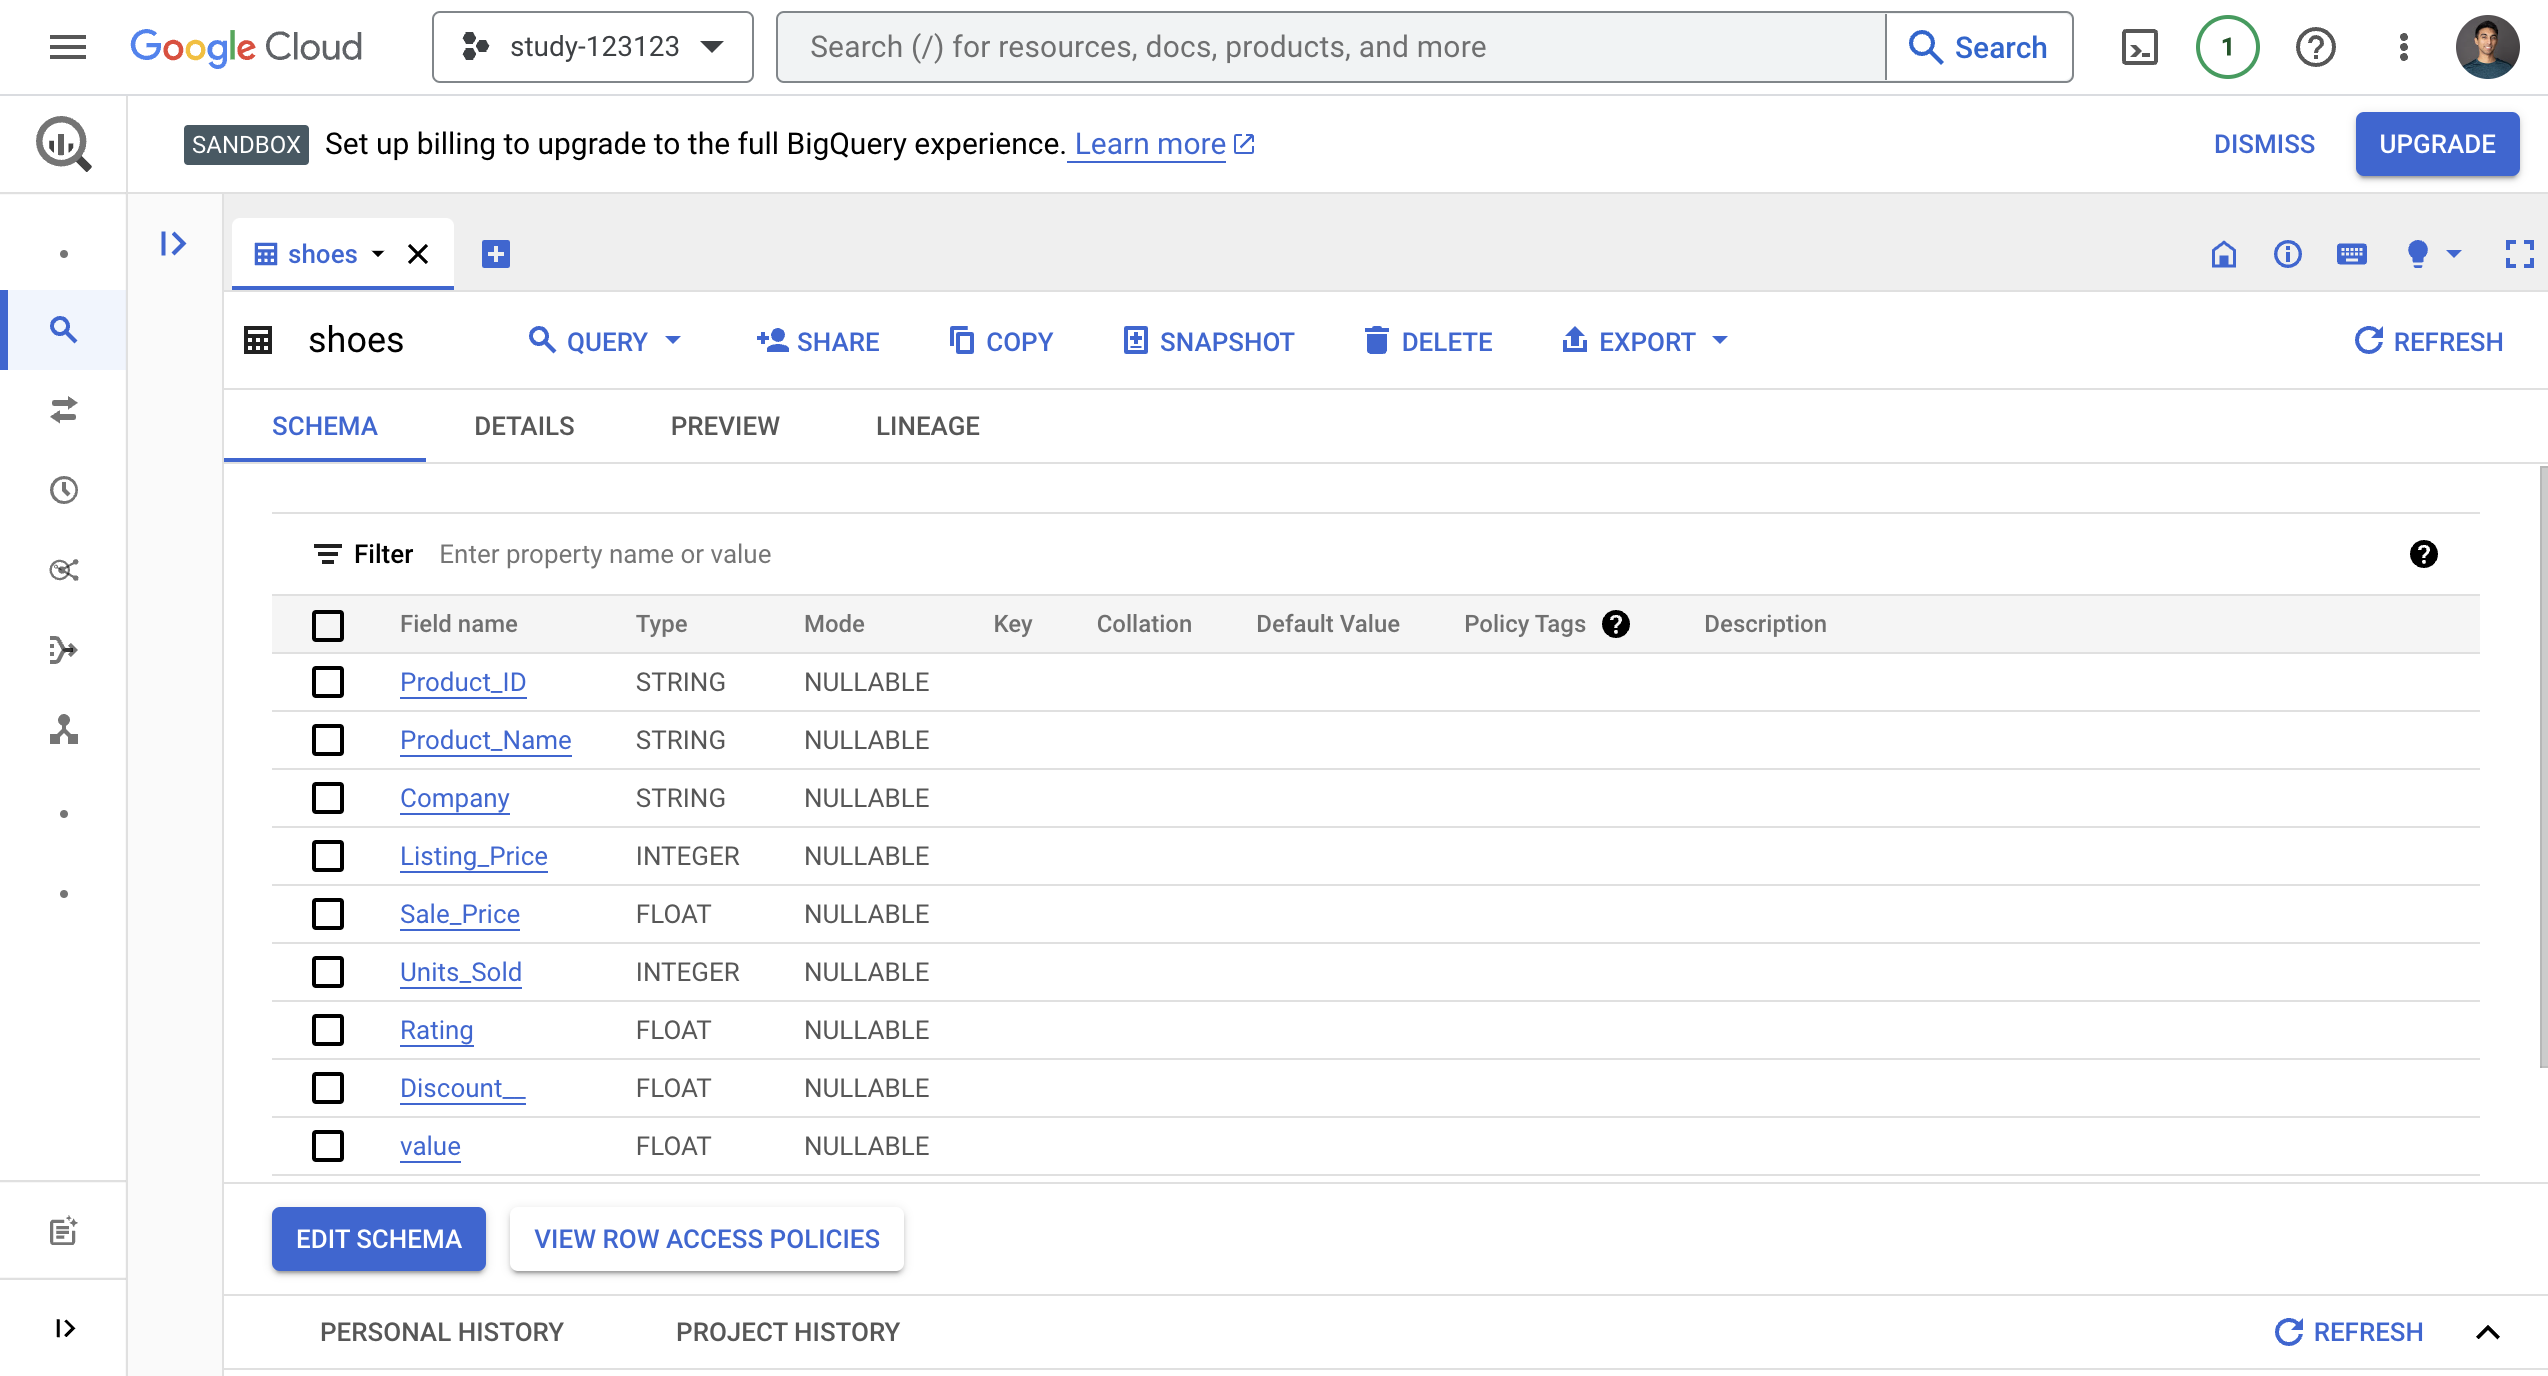

## Analysis

#### Nike and Adidas subsets

In [234]:
# Creating subsets of the data filtered by company
nike = shoes[shoes['Company'] == 'Nike']
adidas = shoes[shoes['Company'] == 'Adidas']

In [235]:
np.round(nike.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Listing Price,554.00,114.24,43.23,16.00,80.00,110.00,150.00,365.00
Sale Price,554.00,29.28,43.85,0.00,0.00,0.00,64.00,160.00
Rating,554.00,3.91,0.80,1.00,3.27,3.90,4.60,5.00
Discount %,554.00,9.88,14.33,0.00,0.00,0.00,20.00,40.00
value,554.00,30.63,14.95,4.00,21.00,28.00,37.00,170.00


In [236]:
np.round(adidas.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Listing Price,2625.00,76.02,40.71,9.00,50.00,66.00,90.00,300.00
Sale Price,2625.00,51.40,35.88,4.00,28.00,40.00,65.00,300.00
Rating,2625.00,3.46,1.01,1.00,2.80,3.50,4.30,5.00
Discount %,2625.00,33.46,20.43,0.00,0.00,40.00,50.00,60.00
value,2625.00,25.00,18.58,2.00,13.00,20.00,31.00,230.00


#### Observation
- **Listing price**: Nike has the most expensive shoe while Adidas has the cheapest
- **Rating**: similar average ratings for shoes, but Nike has smaller standard deviation meaning its ratings are more consistent
- **Discount %**: Adidas is a lot more generous with its discount and has the highest discount at 60%
- **value**: Nike overall provides a better value than Adidas with a higher average and lower standard deviation but Adidas has the highest value shoe
- both companies have 50% of their products between priced between \$50 and \$150, with most ratings between 3.0 and 4.5.

#### Correlation matrix of shoes for both Nike and Adidas

<AxesSubplot: >

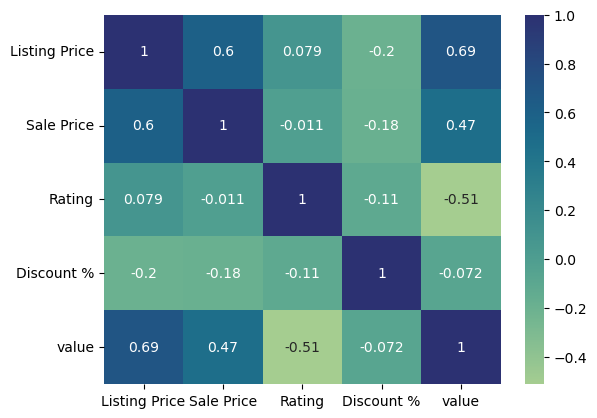

In [237]:
sns.heatmap(shoes.corr().T, annot=True, cmap='crest')

#### Correlation matrix observations
- **Price**: Nike's highest priced shoe at USD 365 indicates a higher-end market positioning compared to Adidas, whose highest is USD 300. Nike shows a broader price range with a higher interquartile range, suggesting a diverse product offering.
- **Ratings**: On average, Nike has higher ratings based off the average and standard deviation.
- **Value**: Nike has a higher average value score with less variability, suggesting more consistent value, whereas Adidas has the highest value shoe at USD 230.
- **Discount**: Adidas offers significantly higher average discounts with more variability, suggesting a strategy focused on sales promotions.
- **Sale Price**: Nike's products have a higher average sale price with a broader range, reinforcing its premium market positioning.

#### Averages across the numerical variables

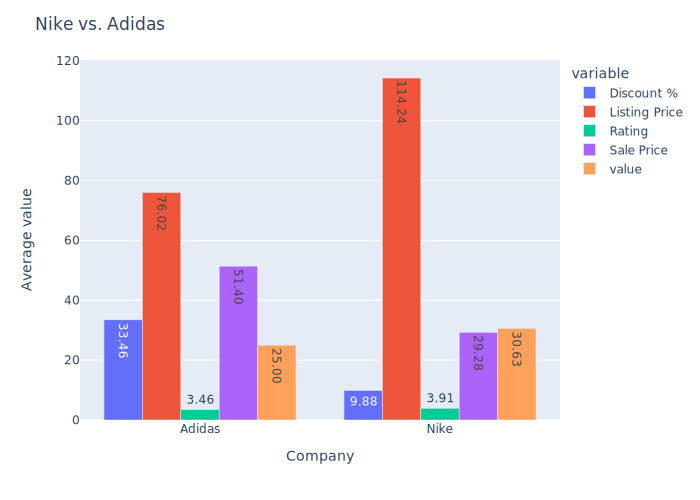

In [238]:
company_avg = shoes.pivot_table(values=['Listing Price','Sale Price','Rating','Discount %',
                                 'value'], index='Company', aggfunc='mean')
# let's vizualize that
fig_comp = px.bar(company_avg, barmode='group')

fig_comp.update_traces(texttemplate='%{y:.2f}', textposition='auto') 

fig_comp.update_layout(title="Nike vs. Adidas", 
                  xaxis_title="Company", yaxis_title='Average value')

#### Observations: Nike vs. Adidas
1. Nike shoes, on average, cost almost $40 more and have 0.66 points higher rating
2. Nike's average sale price is about 30 USD higher
3. Adidas gives higher discounts on average than Nike
4. Adidas however has a higher value ratio than Nike

#### Hypothesis test: skewness of numerical variables 
- We can see from the statistical summary that the variables are not normally distributed but let's make sure with a statistical test : Shapiro - Wilk's test for normality test checks for normality of a numerical varible

In [239]:
############### Listing price ###############
adidas_price = shoes[shoes['Company'] == 'Adidas']['Listing Price']
nike_price = shoes[shoes['Company'] == 'Nike']['Listing Price']
#Discount %
nike_discount = shoes[shoes['Company']=='Nike']['Discount %']
adidas_discount = shoes[shoes['Company']=='Adidas']['Discount %']
# Rating
nike_rating = shoes[shoes['Company']=='Nike']['Rating']
adidas_rating = shoes[shoes['Company']=='Adidas']['Rating']
# Value
nike_value = shoes[shoes['Company']=='Nike']['value']
adidas_value = shoes[shoes['Company']=='Adidas']['value']

############### Function to test normality ###############
def normal_test(alpha, p_val, brand, variable):
    if p_val < alpha:
        return f"{brand}'s {variable} not normally distributed)"
    else:
        return f"{brand}'s {variable} is normally distributed)"
############### Set significance level ###############
alpha = 0.05

############### Perform Shapiro-Wilk test for each variable ###############
adidas_shapiro_price = stats.shapiro(adidas_price)[1]
nike_shapiro_price = stats.shapiro(nike_price)[1]
adidas_shapiro_discount = stats.shapiro(adidas_discount)[1]
nike_shapiro_discount = stats.shapiro(nike_discount)[1]
adidas_shapiro_rating = stats.shapiro(adidas_rating)[1]
nike_shapiro_rating = stats.shapiro(nike_rating)[1]
adidas_shapiro_value = stats.shapiro(adidas_value)[1]
nike_shapiro_value = stats.shapiro(nike_value)[1]
############### Print the results ###############
print(normal_test(alpha, adidas_shapiro_price, "Adidas", "Listing Price"))
print(normal_test(alpha, nike_shapiro_price, "Nike", "Listing Price"))
print(normal_test(alpha, adidas_shapiro_discount, "Adidas", "Discount %"))
print(normal_test(alpha, nike_shapiro_discount, "Nike", "Discount %"))
print(normal_test(alpha, adidas_shapiro_rating, "Adidas", "Rating"))
print(normal_test(alpha, nike_shapiro_rating, "Nike", "Rating"))
print(normal_test(alpha, adidas_shapiro_value, "Adidas", "value"))
print(normal_test(alpha, nike_shapiro_value, "Nike", "value"))

Adidas's Listing Price not normally distributed)
Nike's Listing Price not normally distributed)
Adidas's Discount % not normally distributed)
Nike's Discount % not normally distributed)
Adidas's Rating not normally distributed)
Nike's Rating not normally distributed)
Adidas's value not normally distributed)
Nike's value not normally distributed)


#### Observation
- none of the distributions are normally distributed 

In [240]:
nike_value.describe()

count   554.00
mean     30.63
std      14.95
min       4.00
25%      21.00
50%      28.00
75%      37.00
max     170.00
Name: value, dtype: float64

In [241]:
adidas_value.describe()

count   2625.00
mean      25.00
std       18.58
min        2.00
25%       13.00
50%       20.00
75%       31.00
max      230.00
Name: value, dtype: float64

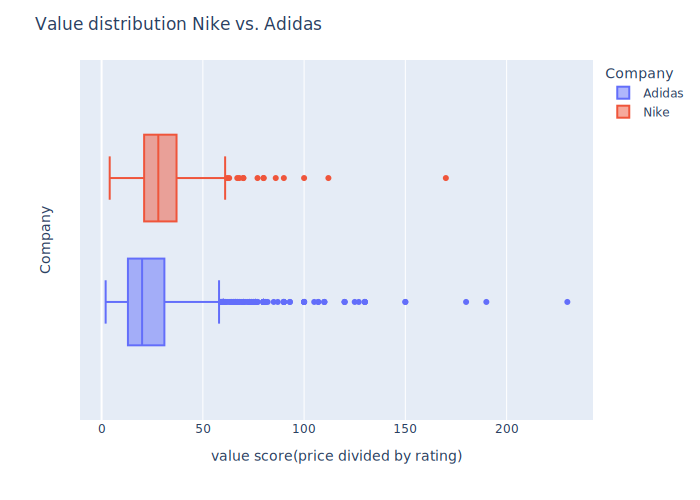

In [242]:
# Listing prices visualized  
fig = px.box(shoes, x="value", color='Company')

fig.update_layout(title="Value distribution Nike vs. Adidas", 
                  xaxis_title="value score(price divided by rating)",
                  yaxis_title="Company")
fig.show()

#### Is there a statistically significant difference in the average value between Nike and Adidas shoes?

State the hypothesis:
* $H_0:$ There is no difference between the two company's average value score
* $H_1:$ there is a difference between the two company's average value score

alpha = 0.05

#### Bootstrapping + hypothesis testing: 
- Since the value score is not normally distributed, we have to do bootstrapping to compare the means with n-# of iterations

In [243]:
n_iterations = 1000
size = len(shoes)

# Initialize arrays to store bootstrap sample means
nike_means = np.zeros(n_iterations)
adidas_means = np.zeros(n_iterations)

# Generate bootstrap samples and compute means
for i in range(n_iterations):
    nike_sample = np.random.choice(nike_value, size=size, replace=True)
    adidas_sample = np.random.choice(adidas_value, size=size, replace=True)
    nike_means[i] = nike_sample.mean()
    adidas_means[i] = adidas_sample.mean()
# Observed difference in means
observed_diff = nike_value.mean() - adidas_value.mean()

# Calculate the difference in bootstrap sample means
diff_means = nike_means - adidas_means

# Calculate the p-value
# The p-value is the probability of getting the observed difference (or more extreme) 
# in the bootstrap samples if the null hypothesis (no difference in means) is true
p_value = np.sum(diff_means >= observed_diff) / n_iterations

# Print the results
print(f"Observed difference in means: {round(observed_diff)}")

if p_value > 0.05:
    print('There is no significant difference in the average value score')
else:
    print('There is a significant difference in the average value score')

Observed difference in means: 6
There is no significant difference in the average value score


#### Observation
- **Perceived Value Similarity**: Customers view Nike and Adidas similarly in terms of price-to-rating ratio.
- **Pricing vs. Ratings**: Despite Nike's higher prices and Adidas's discounts and lower prices, both are perceived to offer comparable value.
- **Adidas's Strategy**: Adidas compensates for its slightly lower ratings with effective pricing, maintaining market competitiveness against Nike.

#### Distribution of discount %

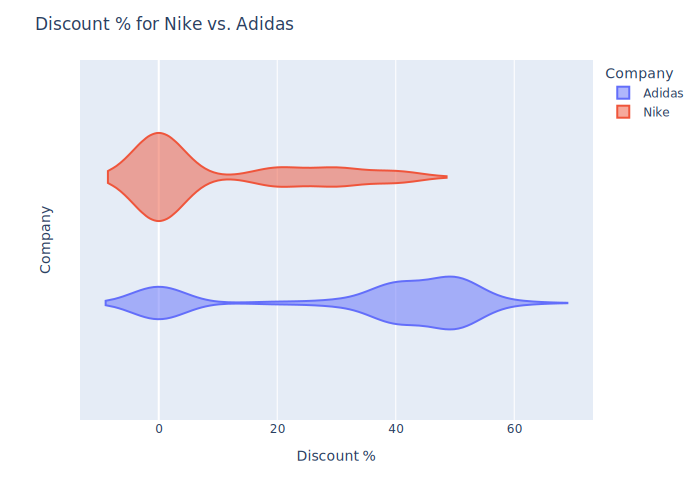

In [244]:
# Let's visualize to see how that looks with a violin plot
fig = px.violin(shoes, x="Discount %", color='Company')

fig.update_layout(title="Discount % for Nike vs. Adidas", 
                  xaxis_title="Discount %",
                  yaxis_title="Company")
fig.show()

#### Observation
- as imagined from the stats summary earlier, Adidas has a larger spread of discounts vs Nike's which seems to be concentrated in the lower amounts. 
- Nike has a right skewed distribution where as Adidas has a bi-modal distribution, 1st concentrating around the lower amounts and 2nd between 40 and 50

#### Rating distribution

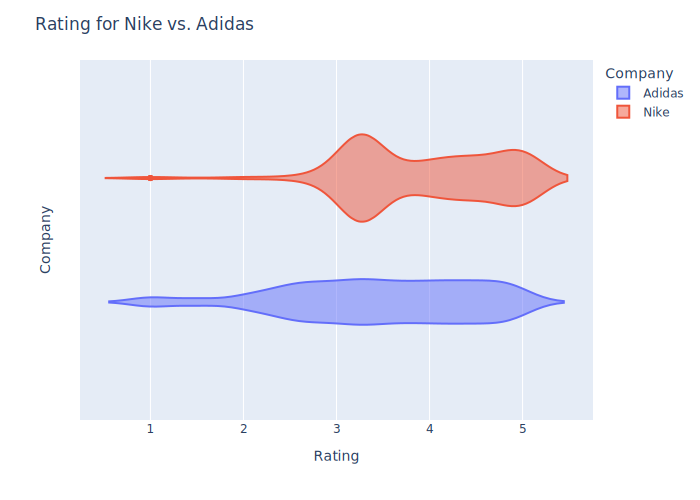

In [245]:
# Let's visualize to see how that looks with a violin plot
fig = px.violin(shoes, x="Rating", color='Company')

fig.update_layout(title="Rating for Nike vs. Adidas", 
                  xaxis_title="Rating",
                  yaxis_title="Company")
fig.show()

#### Observation
- Kind of opposite to the discount % distributions Nike has a bi-modal distribution with shoes mostly in the upper ranges whereas whereas Adidas has a more consistant number of ratings from 3-5 with a larger standard deviation

#### Question: What portion of Nike and Adidas shoes are rated at least a 4.0? 

In [246]:
top_shoes = shoes[shoes['Rating'] >= 4]
print((top_shoes.groupby('Company')['Rating'].count()
                        / shoes.groupby('Company')['Rating'].count() * 100).round())


Company
Adidas   36.00
Nike     49.00
Name: Rating, dtype: float64


#### Observation
- Nike has a much larger portion of their shoes rated 4.0 or higher(almost 1/2) compared
-to Adidas's just over 1/3

#### Regression analysis: Listing price vs. rating

In [247]:
# isolate the variables for regression
X1 = shoes['Listing Price']
y1= shoes['Rating']

X1 = sm.add_constant(X1)

reg1 = sm.OLS(y1, X1).fit()

shoes['best_fit1'] = reg1.predict(X1)

# Print out the R^2 value
print(f"R^2: {reg1.rsquared}")

R^2: 0.006294308180669228


#### Observation
- less than 1% of change in listing price accounts for rating, indicating other factors like brand image might be more influential and a shoe's rating may be more tied to customer's perception rather than the actual quality of the shoe

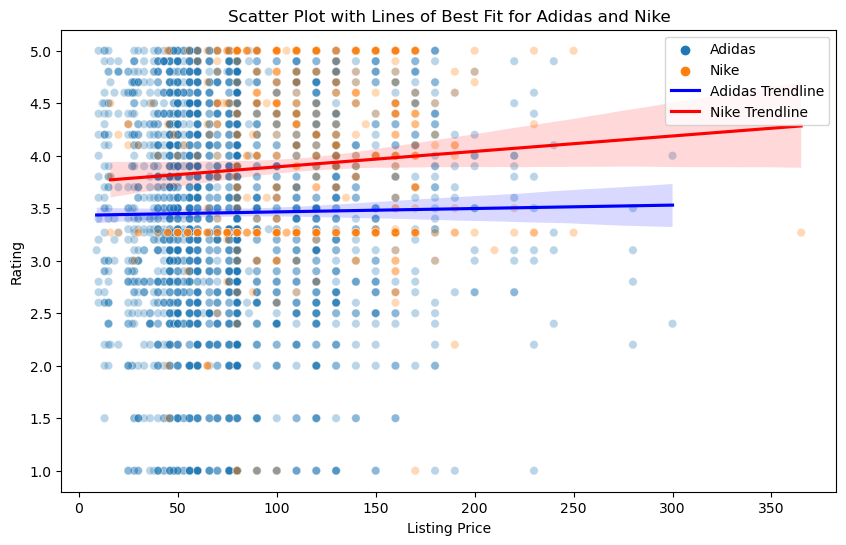

In [248]:
# Scatter plot with Seaborn including all data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=shoes, x='Listing Price', y='Rating', hue='Company', alpha=0.3)

# Regression line for Adidas
sns.regplot(data=shoes_adidas, x='Listing Price', y='Rating', scatter=False, 
            color='blue', label='Adidas Trendline')

# Regression line for Nike
sns.regplot(data=shoes_nike, x='Listing Price', y='Rating', scatter=False,
            color='red', label='Nike Trendline')

# Add title and labels as needed
plt.title('Scatter Plot with Lines of Best Fit for Adidas and Nike')
plt.xlabel('Listing Price')
plt.ylabel('Rating')

# Show the plot
plt.legend()
plt.show()

#### Observations from Regression Analysis:
- Adidas's trendlind is higher than Nike's, indicating a better average rating at similar price points
- Nike's confidence interval is wider than Adidas', showing more variation in ratings at higher prices

## Insights and Recommendations
- As hypothesised, relationship between shoe quality/rating and price is influenced by the strong brand image rather than actual quality of the shoe
- Post-cleaning data shows Nike's shoes are more expensive but also higher rated than Adidas. This aligns with Nike's dominant position in the market of Athleisure-wear.
- Adidas employs strategic discounts (up to 60%), which probably drives sales for those considering buying a sport shoe on price alone, and aren't as loyal to a brand. 
- Conversely, Nike's discount strategy is less clear so Adidas may benefit from enhancing their brand to compete directly with Nike, potentially allowing for higher pricing based on perceived value
- Both brands could adjust their discount strategies, offering larger discounts on expensive items and smaller discounts on lower-priced items, balancing sales attraction with brand image maintenance